In [1]:
# ObsData <- readRDS('../data/rhcAnalytic.RDS')
ObsData = read.csv('../data/rhcData_p.csv',header=TRUE)
ObsData = ObsData[,-1]
min.Y <- min(ObsData$Y)
max.Y <- max(ObsData$Y)
ObsData$Y.bounded <- (ObsData$Y-min.Y)/(max.Y-min.Y)

In [2]:
# str(ObsData)

In [3]:
library(SuperLearner)
set.seed(123)
ObsData.noY <- dplyr::select(ObsData, !c(Y,Y.bounded))
Y.fit.sl <- SuperLearner(Y=ObsData$Y.bounded, 
                       X=ObsData.noY, 
                       cvControl = list(V = 3),
                       SL.library=c("SL.glm", 
                                    "SL.glmnet", 
                                    "SL.xgboost"),
                       method="method.CC_nloglik", 
                       family="gaussian")

 要求されたパッケージ nnls をロード中です 

 要求されたパッケージ gam をロード中です 

 要求されたパッケージ splines をロード中です 

 要求されたパッケージ foreach をロード中です 

Loaded gam 1.20.2


Super Learner

Version: 2.0-28

Package created on 2021-05-04


 要求されたパッケージ nloptr をロード中です 

 要求されたパッケージ glmnet をロード中です 

 要求されたパッケージ xgboost をロード中です 



In [4]:
ObsData$init.Pred <- predict(Y.fit.sl, newdata = ObsData.noY, 
                           type = "response")$pred

In [5]:
ObsData.noY$A <- 1
ObsData$Pred.Y1 <- predict(Y.fit.sl, newdata = ObsData.noY, 
                           type = "response")$pred

ObsData.noY$A <- 0
ObsData$Pred.Y0 <- predict(Y.fit.sl, newdata = ObsData.noY, 
                           type = "response")$pred

In [6]:
ObsData$Pred.TE <- ObsData$Pred.Y1 - ObsData$Pred.Y0   

In [7]:
ObsData.noYA <- dplyr::select(ObsData, !c(Y,Y.bounded,
                                          A,init.Pred,
                                          Pred.Y1,Pred.Y0,
                                          Pred.TE))

In [8]:
set.seed(124)

PS.fit.SL <- SuperLearner(Y=ObsData$A, 
                       X=ObsData.noYA, 
                       cvControl = list(V = 3),
                       SL.library=c("SL.glm", 
                                    "SL.glmnet", 
                                    "SL.xgboost"),
                       method="method.CC_nloglik",
                       family="binomial")  

all.pred <- predict(PS.fit.SL, type = "response")
ObsData$PS.SL <- all.pred$pred 

In [12]:
# ここについては全員1である必要がある？（調べる）
# =>スコア方程式を満たさなくなってしまうので間違っていそう
ObsData$H.A1L <- (ObsData$A) / ObsData$PS.SL 
ObsData$H.A0L <- (1-ObsData$A) / (1- ObsData$PS.SL)
# ObsData$H.A1L <- 1 / ObsData$PS.SL 
# ObsData$H.A0L <- 1 / (1- ObsData$PS.SL)
ObsData$H.AL <- ObsData$H.A1L - ObsData$H.A0L

eps_mod <- glm(Y.bounded ~ -1 + H.A1L + H.A0L + offset(qlogis(init.Pred)) , 
               family = "quasibinomial",
               data = ObsData)
epsilon <- coef(eps_mod)  
epsilon

H.A1L      H.A0L 
0.01537137 0.02497578

In [26]:
# ObsData$Pred.Y1.update <- plogis(qlogis(ObsData$Pred.Y1) +  
#                                    epsilon["H.A1L"]*1 / ObsData$PS.SL )

# ObsData$Pred.Y0.update <- plogis(qlogis(ObsData$Pred.Y0) + 
#                                    epsilon["H.A0L"]*1/ (1- ObsData$PS.SL))
ObsData$Pred.Y1.update <- plogis(qlogis(ObsData$Pred.Y1) +  
                                   epsilon["H.A1L"]*ObsData$A / ObsData$PS.SL )

ObsData$Pred.Y0.update <- plogis(qlogis(ObsData$Pred.Y0) + 
                                   epsilon["H.A0L"]*(1-ObsData$A)/ (1- ObsData$PS.SL))

In [27]:
TE <- mean(ObsData$Pred.Y1.update - ObsData$Pred.Y0.update)
TE  <- TE*(max.Y-min.Y)
TE

[1] 3.067865

In [28]:
ci.estimate <- function(data = ObsData, H.AL.components = 1){
  min.Y <- min(data$Y)
  max.Y <- max(data$Y)
  # transform predicted outcomes back to original scale
  if (H.AL.components == 2){
    data$Pred.Y1.update.rescaled <- 
      (max.Y- min.Y)*data$Pred.Y1.update + min.Y
    data$Pred.Y0.update.rescaled <- 
      (max.Y- min.Y)*data$Pred.Y0.update + min.Y
  } 
  if (H.AL.components == 1) {
    data$Pred.Y1.update.rescaled <- 
      (max.Y- min.Y)*data$Pred.Y1.update1 + min.Y
    data$Pred.Y0.update.rescaled <- 
      (max.Y- min.Y)*data$Pred.Y0.update1 + min.Y
  }
  EY1_TMLE1 <- mean(data$Pred.Y1.update.rescaled, 
                    na.rm = TRUE)
  EY0_TMLE1 <- mean(data$Pred.Y0.update.rescaled, 
                    na.rm = TRUE)
  # ATE efficient influence curve
  D1 <- data$A/data$PS.SL*
    (data$Y - data$Pred.Y1.update.rescaled) + 
    data$Pred.Y1.update.rescaled - EY1_TMLE1
  D0 <- (1 - data$A)/(1 - data$PS.SL)*
    (data$Y - data$Pred.Y0.update.rescaled) + 
    data$Pred.Y0.update.rescaled - EY0_TMLE1
  EIC <- D1 - D0
  # ATE variance
  n <- nrow(data)
  varHat.IC <- var(EIC, na.rm = TRUE)/n
  # ATE 95% CI
  if (H.AL.components == 2) {
    ATE.TMLE.CI <- c(ATE.TMLE - 1.96*sqrt(varHat.IC), 
                   ATE.TMLE + 1.96*sqrt(varHat.IC))
  }
  if (H.AL.components == 1) {
    ATE.TMLE.CI <- c(ATE.TMLE1 - 1.96*sqrt(varHat.IC), 
                   ATE.TMLE1 + 1.96*sqrt(varHat.IC))
  }
  return(ATE.TMLE.CI) 
}

ATE.TMLE.bounded.vector <- ObsData$Pred.Y1.update - ObsData$Pred.Y0.update

ATE.TMLE.bounded <- mean(ATE.TMLE.bounded.vector, na.rm = TRUE) 

ATE.TMLE <- (max.Y-min.Y)*ATE.TMLE.bounded  

In [29]:
CI2 <- ci.estimate(data = ObsData, H.AL.components = 2) 
CI2

[1] 2.003238 4.132491

PSの導出をさまざまなモデルで

In [140]:
lib_glm = c("SL.glm" )
lib_rpart = c('SL.rpart')
lib_forest = c('SL.randomForest')
lib_gbm = c("SL.gbm")
lib_cforest = c('SL.cforest')
lib_xgboost = c('SL.xgboost')
lib_svm = c('SL.svm')
# lib_ksvm = c('SL.ksvm')
lib_lda = c('SL.lda')
lib_lm = c('SL.lm')
lib_knn = c('SL.knn')
lib_only_tree = c("SL.rpart","SL.gbm","SL.xgboost",'SL.randomForest','SL.cforest')
lib_tree_and_glm = c("SL.rpart","SL.gbm","SL.xgboost",'SL.randomForest','SL.cforest',"SL.glm")
lib_only_simple = c('SL.lm','SL.rpart','SL.glm')
lib_only_linear = c("SL.glm","SL.lm","SL.lda")
lib_only_complex = c('SL.randomForest','SL.xgboost','SL.svm')
lib_1 = c("SL.glm","SL.xgboost","SL.randomForest",'SL.svm')
lib_2 = c("SL.glm","SL.xgboost","SL.randomForest",'SL.svm','SL.lm')
lib_3 = c("SL.glm","SL.xgboost","SL.randomForest",'SL.svm','SL.lm','SL.lda')
lib_test = c("SL.lda")
lib_list = list(
                lib_glm,
                lib_lda,
                lib_lm,
                lib_rpart,
                lib_forest,
#                 lib_cforest,
                lib_gbm,
                lib_xgboost,
                lib_svm,
                lib_knn,
                lib_only_tree,
                lib_tree_and_glm,
                lib_only_simple,
                lib_only_linear,
                lib_only_complex,
                lib_1,
                lib_2,
                lib_3
                )

[1] "Done"


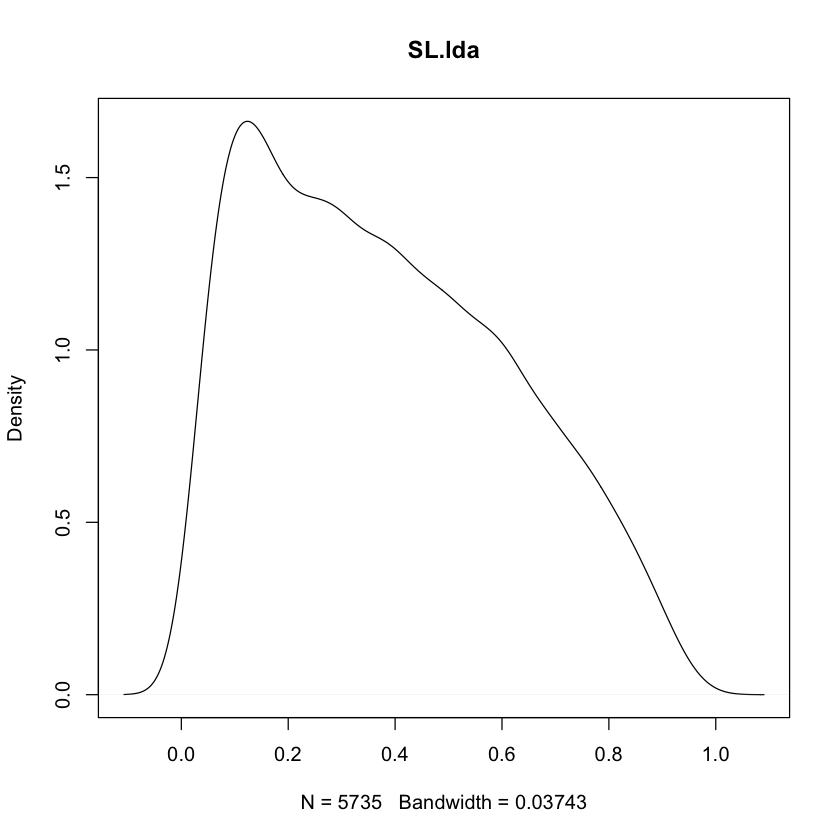

In [141]:
set.seed(124)
PS.fit.SL <- SuperLearner(Y=ObsData$A, 
                       X=ObsData.noYA, 
                       cvControl = list(V = 3),
                       SL.library=lib_test,
                       method="method.CC_nloglik",
                       family="binomial")  

all.pred <- predict(PS.fit.SL, type = "response")
print('Done')
plot(density(all.pred$pred), main = lib_test)

In [63]:
# ここについては全員1である必要がある？（調べる）
# =>スコア方程式を満たさなくなってしまうので間違っていそう
ObsData$H.A1L <- (ObsData$A) / all.pred$pred
ObsData$H.A0L <- (1-ObsData$A) / (1- all.pred$pred)
# ObsData$H.A1L <- 1 / ObsData$PS.SL 
# ObsData$H.A0L <- 1 / (1- ObsData$PS.SL)
ObsData$H.AL <- ObsData$H.A1L - ObsData$H.A0L

eps_mod <- glm(Y.bounded ~ -1 + H.A1L + H.A0L + offset(qlogis(init.Pred)) , 
               family = "quasibinomial",
               data = ObsData)
epsilon <- coef(eps_mod)  
epsilon

H.A1L      H.A0L 
0.00713722 0.01553409

In [64]:
ObsData$Pred.Y1.update <- plogis(qlogis(ObsData$Pred.Y1) +  
                                   epsilon["H.A1L"]*1 / all.pred$pred )

ObsData$Pred.Y0.update <- plogis(qlogis(ObsData$Pred.Y0) + 
                                   epsilon["H.A0L"]*1/ (1- all.pred$pred))

TE <- mean(ObsData$Pred.Y1.update - ObsData$Pred.Y0.update)
TE  <- TE*(max.Y-min.Y)
ATE.TMLE.bounded.vector <- ObsData$Pred.Y1.update - ObsData$Pred.Y0.update

ATE.TMLE.bounded <- mean(ATE.TMLE.bounded.vector, na.rm = TRUE) 

ATE.TMLE <- (max.Y-min.Y)*ATE.TMLE.bounded  

CI = ci.estimate(data = ObsData, H.AL.components = 2) 

In [65]:
TE
CI

[1] 3.385406

[1] 2.320671 4.450140

mmmmmmm

In [142]:
set.seed(124)
outcome = list()
lib_name = list()
for(lib in lib_list){
    PS.fit.SL <- SuperLearner(Y=ObsData$A, 
                           X=ObsData.noYA, 
                           cvControl = list(V = 3),
                           SL.library=lib,
                           method="method.CC_nloglik",
                           family="binomial")  
    all.pred <- predict(PS.fit.SL, type = "response")
    outcome = c(outcome,list(all.pred$pred))
    lib_name = c(lib_name,list(lib))
    print(lib)
    print('Done')
    
}

[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"


ERROR: Error in get(library$library$predAlgorithm[s], envir = env):  オブジェクト 'SL.ramdomForest' がありません 


In [152]:
TE_list = list()
CI_list = list()
for(ps in outcome){
    df_ps = data.frame(ps)
    ObsData$H.A1L <- (ObsData$A) / df_ps[,1]
    ObsData$H.A0L <- (1-ObsData$A) / (1- df_ps[,1])
    
    ObsData$H.AL <- ObsData$H.A1L - ObsData$H.A0L
    eps_mod <- glm(Y.bounded ~ -1 + H.A1L + H.A0L + offset(qlogis(init.Pred)) , 
               family = "quasibinomial",
               data = ObsData)
    epsilon <- coef(eps_mod)  
    ObsData$Pred.Y1.update <- plogis(qlogis(ObsData$Pred.Y1) +  
                                   epsilon["H.A1L"]*1 / df_ps[,1] )

    ObsData$Pred.Y0.update <- plogis(qlogis(ObsData$Pred.Y0) + 
                                   epsilon["H.A0L"]*1/ (1-df_ps[,1]))
    
    TE <- mean(ObsData$Pred.Y1.update - ObsData$Pred.Y0.update)
    TE  <- TE*(max.Y-min.Y)
    
    ATE.TMLE.bounded.vector <- ObsData$Pred.Y1.update - ObsData$Pred.Y0.update
    ATE.TMLE.bounded <- mean(ATE.TMLE.bounded.vector, na.rm = TRUE) 
    ATE.TMLE <- (max.Y-min.Y)*ATE.TMLE.bounded  

    CI = ci.estimate(data = ObsData, H.AL.components = 2) 

    CI_list = c(CI_list,list(CI))
    TE_list = c(TE_list,list(TE))
    print('Done')
}

[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"
[1] "Done"


In [153]:
CI_list

[[1]]
[1] 2.320671 4.450140

[[2]]
[1] 2.355835 4.484356

[[3]]
[1] 1.838571 3.969482

[[4]]
[1] 2.381350 4.505589

[[5]]
[1] 6.601951 8.953203

[[6]]
[1] 2.093431 4.217605

[[7]]
[1] 25.23772 30.22357

[[8]]
[1] 2.328868 4.453150

[[9]]
[1] 19.13608 24.18124

[[10]]
[1] 3.696727 5.834689

[[11]]
[1] 4.263773 6.422896

[[12]]
[1] 2.361266 4.491186

[[13]]
[1] 2.253893 4.384790

[[14]]
[1] 7.337852 9.712109

In [154]:
TE_list

[[1]]
[1] 3.385406

[[2]]
[1] 3.420096

[[3]]
[1] 2.904026

[[4]]
[1] 3.443469

[[5]]
[1] 7.777577

[[6]]
[1] 3.155518

[[7]]
[1] 27.73065

[[8]]
[1] 3.391009

[[9]]
[1] 21.65866

[[10]]
[1] 4.765708

[[11]]
[1] 5.343334

[[12]]
[1] 3.426226

[[13]]
[1] 3.319342

[[14]]
[1] 8.524981

In [146]:
lib_name

[[1]]
[1] "SL.glm"

[[2]]
[1] "SL.lda"

[[3]]
[1] "SL.lm"

[[4]]
[1] "SL.rpart"

[[5]]
[1] "SL.randomForest"

[[6]]
[1] "SL.gbm"

[[7]]
[1] "SL.xgboost"

[[8]]
[1] "SL.svm"

[[9]]
[1] "SL.knn"

[[10]]
[1] "SL.rpart"        "SL.gbm"          "SL.xgboost"      "SL.randomForest"
[5] "SL.cforest"     

[[11]]
[1] "SL.rpart"        "SL.gbm"          "SL.xgboost"      "SL.randomForest"
[5] "SL.cforest"      "SL.glm"         

[[12]]
[1] "SL.lm"    "SL.rpart" "SL.glm"  

[[13]]
[1] "SL.glm" "SL.lm"  "SL.lda"

[[14]]
[1] "SL.randomForest" "SL.xgboost"      "SL.svm"

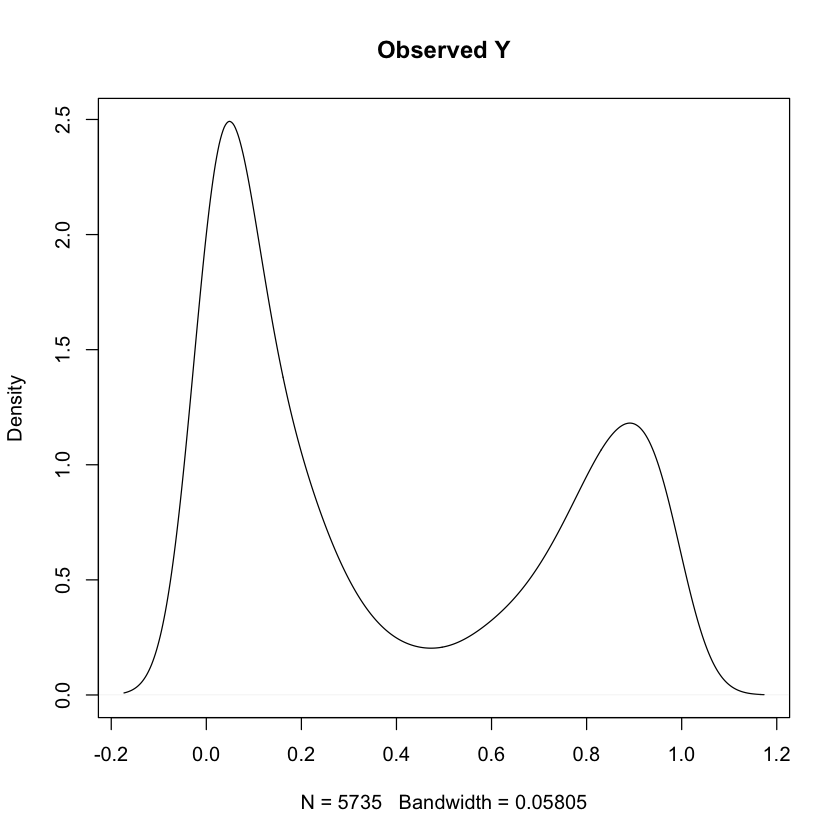

In [88]:
plot(density(data.frame(outcome[4])[,1]), main = "Observed Y")

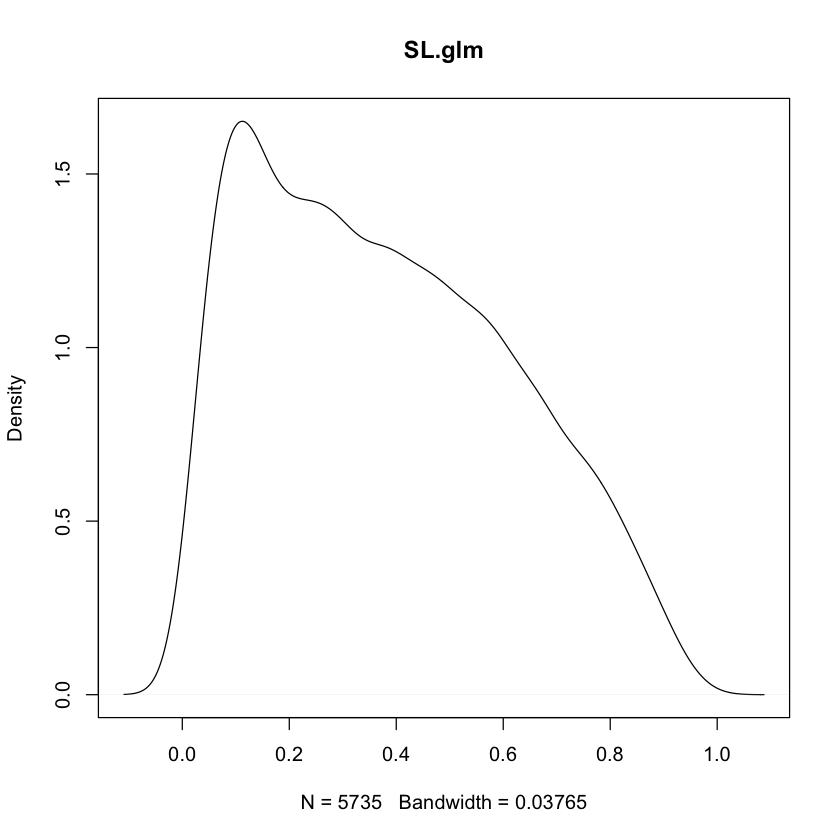

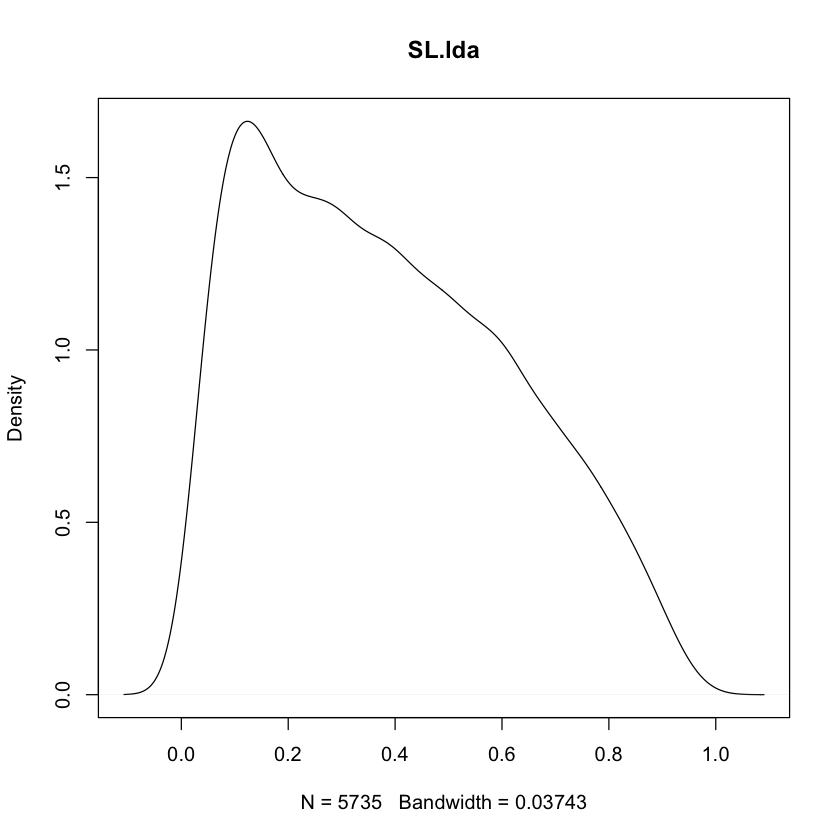

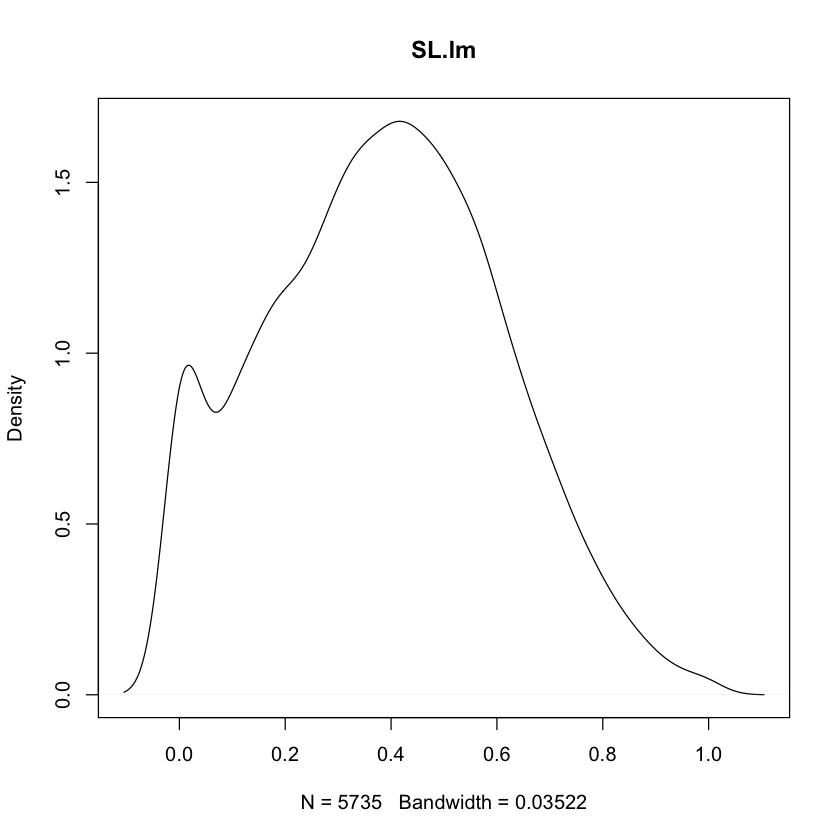

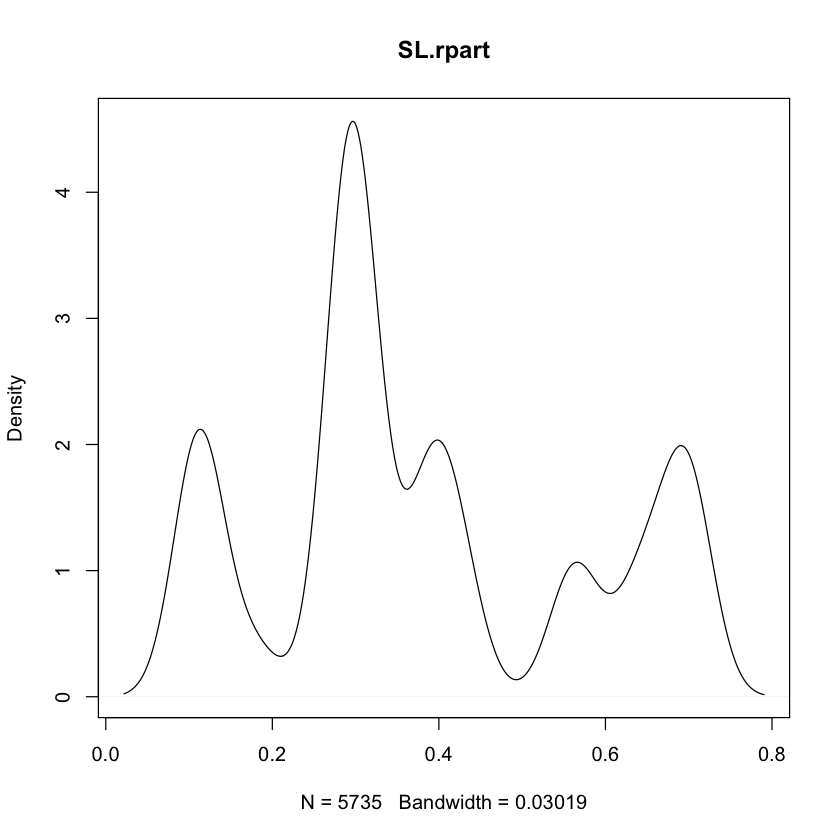

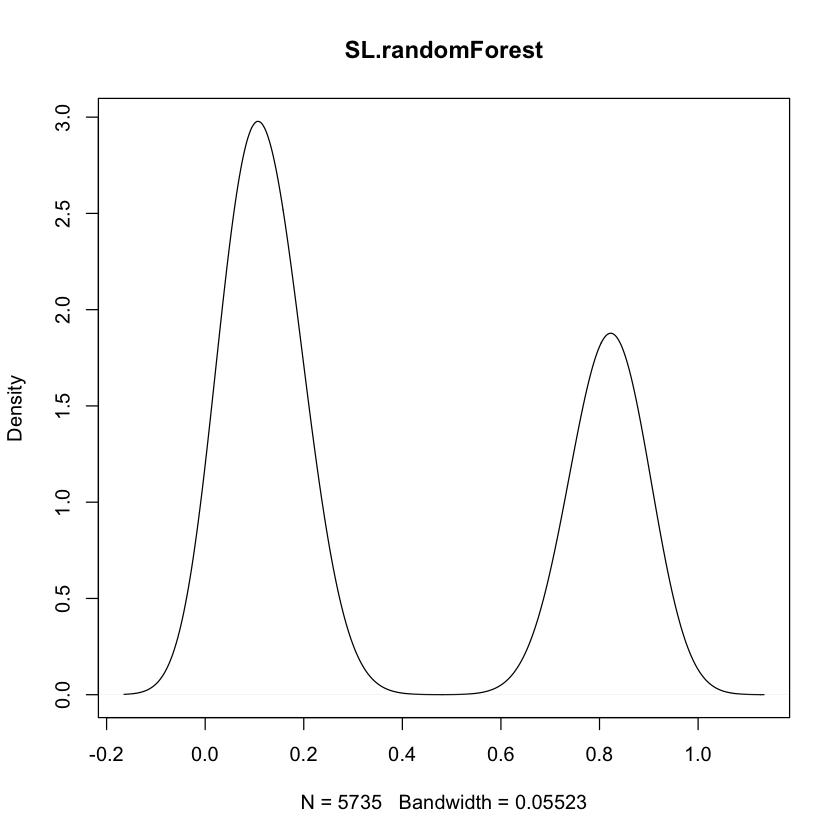

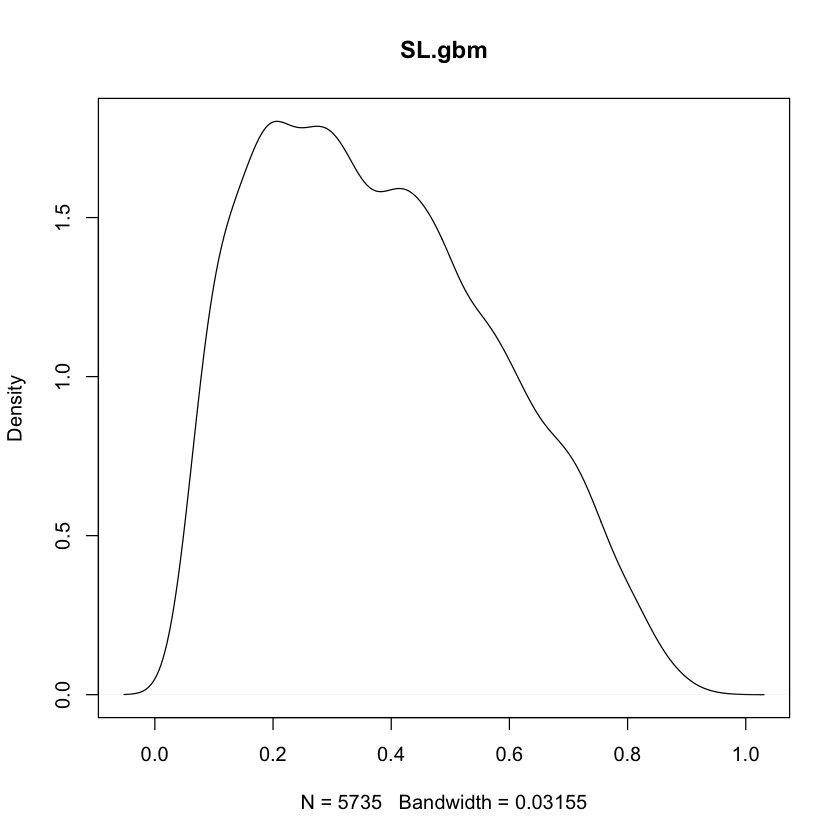

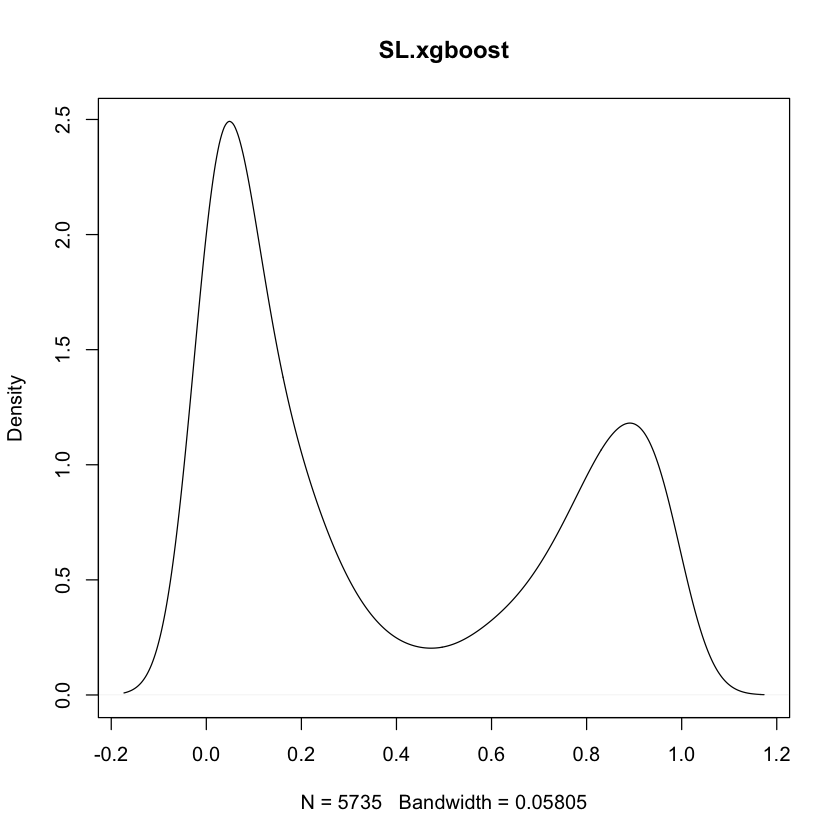

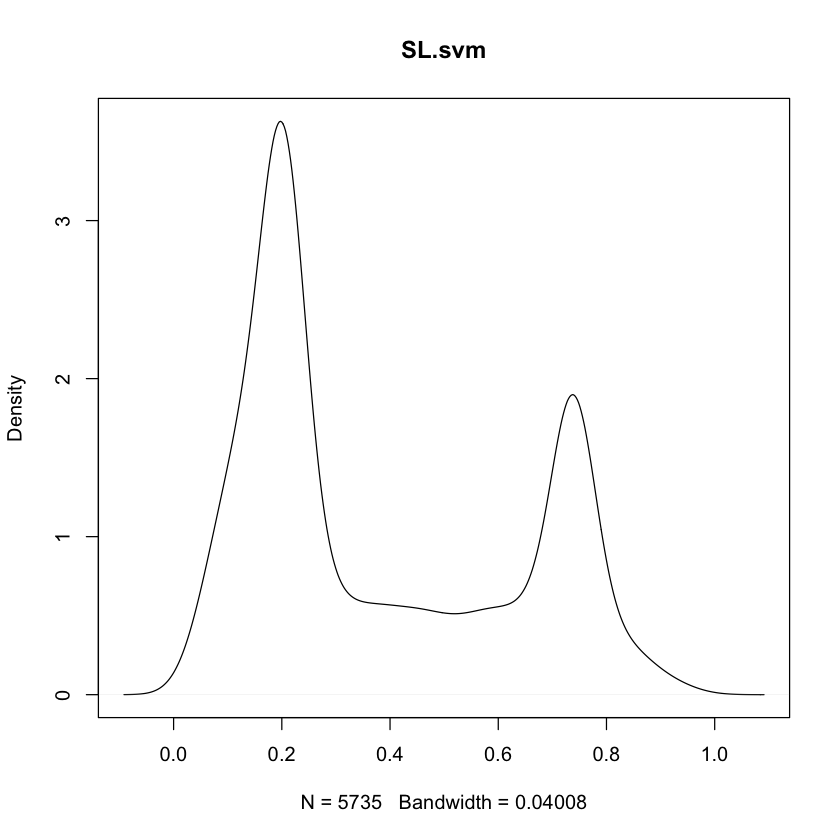

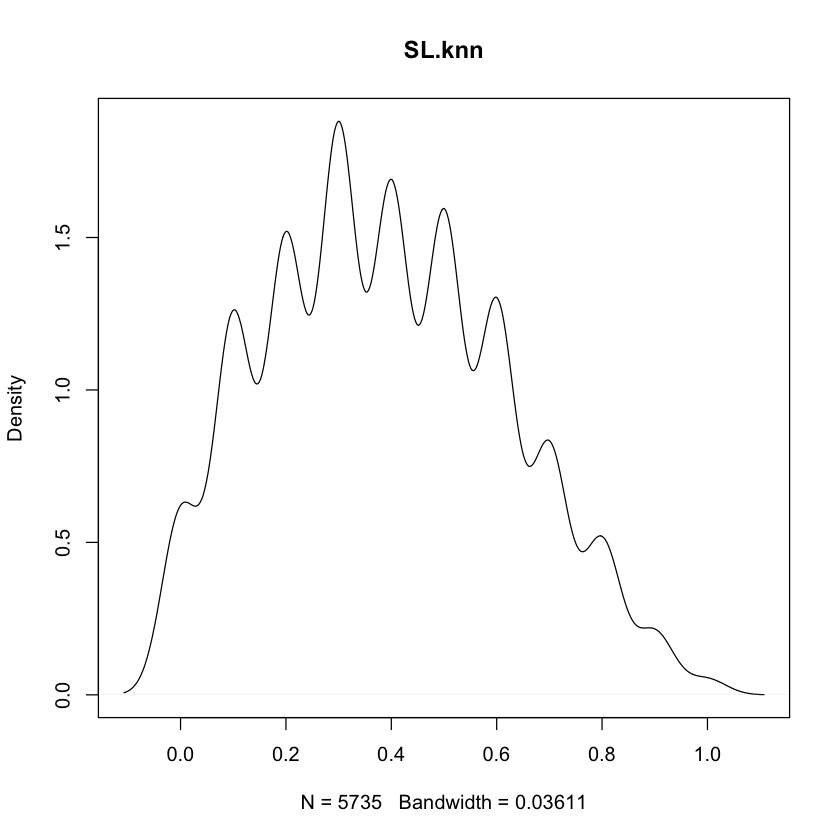

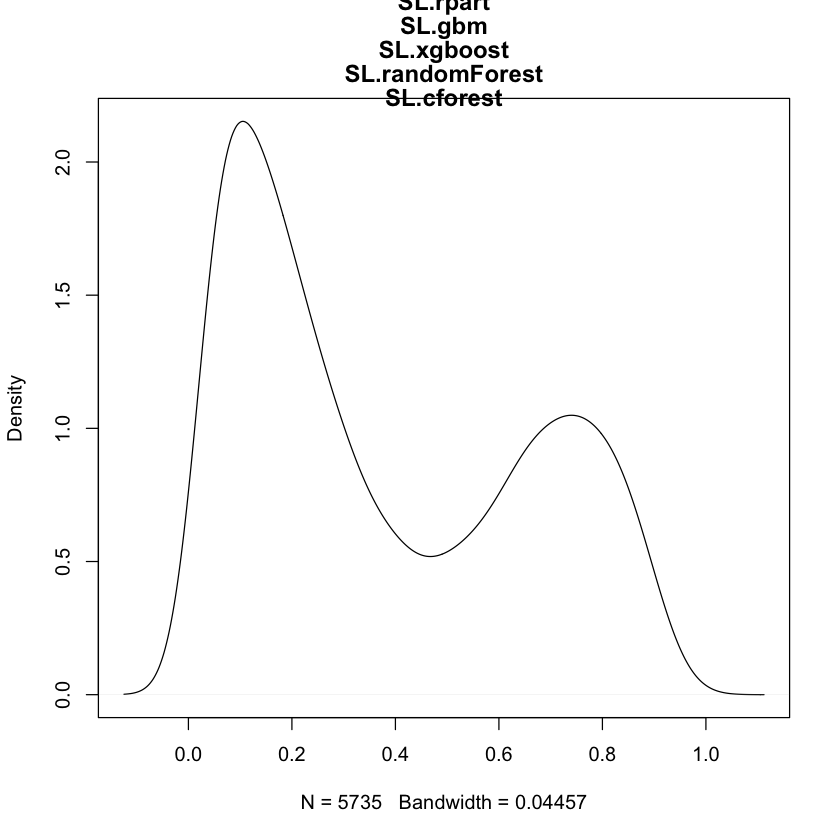

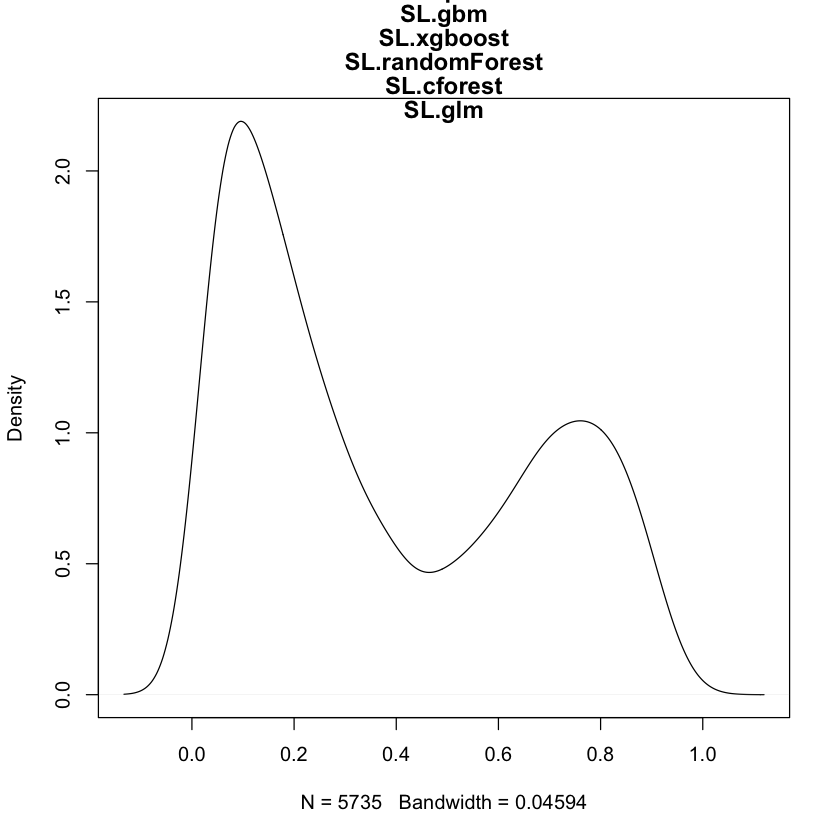

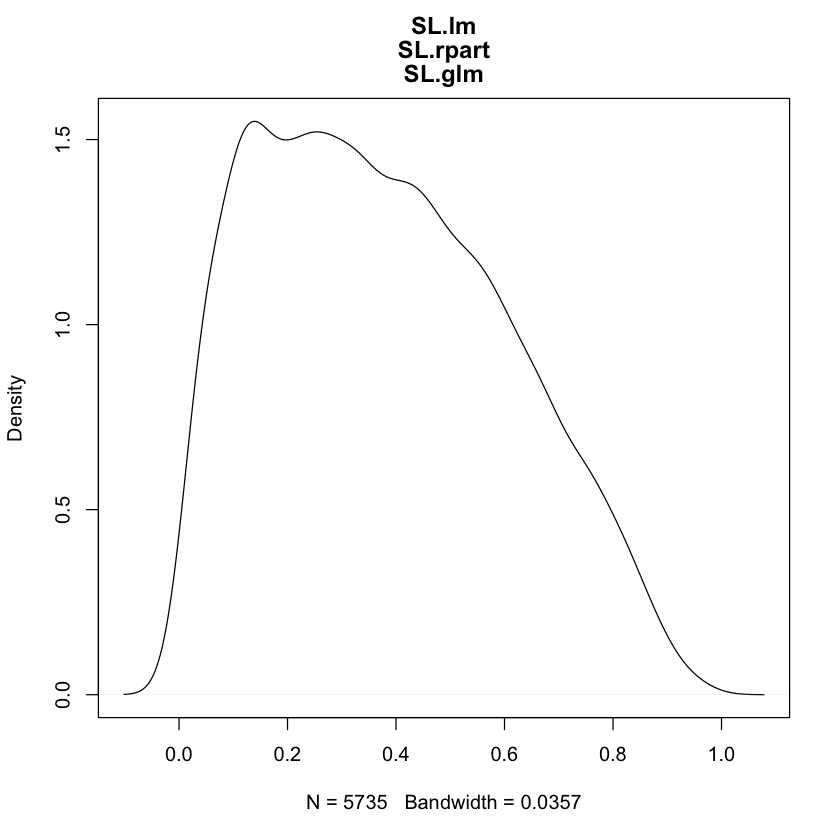

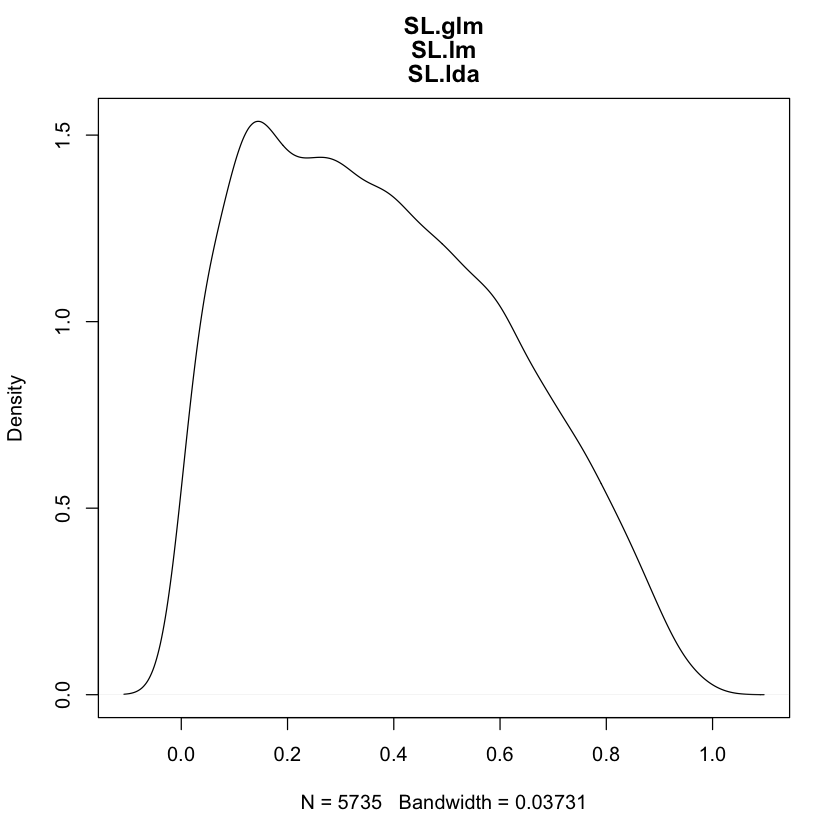

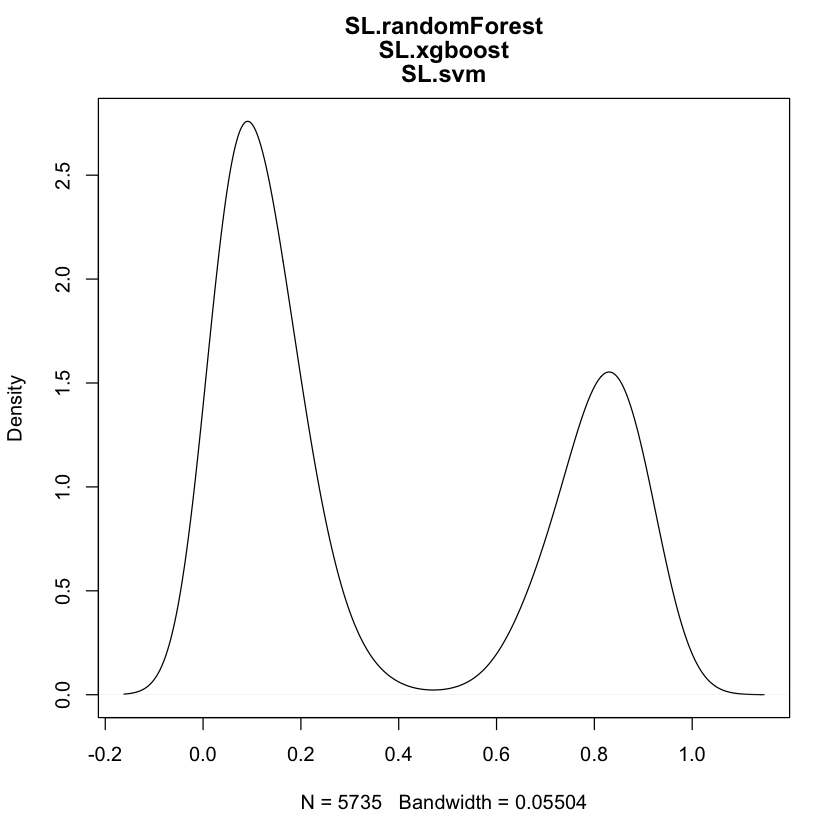

In [143]:
i=0
for(out in outcome){

    i = i +1
    plot(density(data.frame(out)[,1]), main = lib_name[i])
}

In [131]:
data = data.frame(outcome[3])[,1]
data[data<0.4]

[1] 0.142 0.107 0.024 0.143 0.092 0.105 0.113 0.111 0.146 0.126 0.149 0.288
  [13] 0.109 0.202 0.069 0.166 0.231 0.228 0.150 0.058 0.059 0.096 0.202 0.063
  [25] 0.083 0.160 0.082 0.159 0.201 0.074 0.136 0.019 0.094 0.057 0.152 0.094
  [37] 0.152 0.223 0.112 0.131 0.177 0.146 0.138 0.125 0.156 0.144 0.082 0.168
  [49] 0.016 0.074 0.110 0.168 0.105 0.124 0.023 0.042 0.276 0.129 0.010 0.095
  [61] 0.154 0.093 0.027 0.144 0.088 0.082 0.090 0.115 0.057 0.130 0.039 0.076
  [73] 0.098 0.080 0.091 0.111 0.051 0.032 0.131 0.132 0.205 0.112 0.017 0.098
  [85] 0.057 0.234 0.259 0.100 0.050 0.161 0.034 0.150 0.166 0.061 0.032 0.078
  [97] 0.074 0.128 0.083 0.244 0.186 0.164 0.018 0.099 0.018 0.092 0.094 0.219
 [109] 0.091 0.061 0.053 0.120 0.098 0.044 0.203 0.202 0.080 0.126 0.019 0.125
 [121] 0.145 0.036 0.102 0.037 0.084 0.109 0.077 0.061 0.170 0.237 0.180 0.194
 [133] 0.099 0.123 0.059 0.072 0.073 0.116 0.045 0.055 0.116 0.095 0.069 0.153
 [145] 0.128 0.115 0.077 0.034 0.075 0.204 0.131 0.143 0.071 0.019 0.037 0.027
 [157] 0.014 0.211 0.085 0.148 0.033 0.124 0.159 0.218 0.221 0.029 0.074 0.156
 [169] 0.117 0.104 0.106 0.137 0.122 0.104 0.171 0.110 0.156 0.104 0.120 0.164
 [181] 0.148 0.055 0.112 0.072 0.115 0.049 0.067 0.081 0.052 0.152 0.087 0.064
 [193] 0.043 0.088 0.123 0.061 0.071 0.044 0.152 0.111 0.135 0.193 0.080 0.215
 [205] 0.174 0.186 0.083 0.035 0.068 0.180 0.183 0.032 0.044 0.094 0.154 0.085
 [217] 0.147 0.113 0.152 0.123 0.056 0.095 0.146 0.116 0.175 0.071 0.040 0.076
 [229] 0.167 0.190 0.017 0.289 0.150 0.171 0.049 0.251 0.154 0.063 0.197 0.140
 [241] 0.112 0.162 0.079 0.068 0.132 0.159 0.041 0.075 0.107 0.052 0.122 0.219
 [253] 0.038 0.089 0.050 0.121 0.183 0.139 0.131 0.018 0.123 0.059 0.080 0.154
 [265] 0.067 0.101 0.204 0.014 0.041 0.044 0.118 0.170 0.078 0.270 0.043 0.058
 [277] 0.143 0.144 0.143 0.151 0.054 0.214 0.110 0.225 0.189 0.067 0.119 0.097
 [289] 0.105 0.200 0.049 0.061 0.092 0.169 0.084 0.120 0.137 0.116 0.033 0.099
 [301] 0.109 0.108 0.133 0.022 0.038 0.079 0.110 0.054 0.134 0.278 0.094 0.185
 [313] 0.153 0.091 0.276 0.059 0.083 0.108 0.106 0.105 0.178 0.167 0.026 0.211
 [325] 0.203 0.109 0.208 0.031 0.026 0.058 0.207 0.055 0.126 0.084 0.171 0.138
 [337] 0.055 0.100 0.170 0.112 0.228 0.020 0.054 0.124 0.181 0.037 0.099 0.149
 [349] 0.062 0.070 0.149 0.125 0.054 0.198 0.024 0.111 0.155 0.205 0.081 0.052
 [361] 0.109 0.076 0.061 0.024 0.034 0.073 0.111 0.013 0.036 0.099 0.136 0.208
 [373] 0.192 0.083 0.080 0.117 0.051 0.113 0.189 0.189 0.012 0.150 0.060 0.093
 [385] 0.172 0.093 0.189 0.176 0.123 0.093 0.043 0.036 0.060 0.046 0.085 0.232
 [397] 0.127 0.258 0.076 0.216 0.151 0.128 0.130 0.167 0.024 0.052 0.105 0.118
 [409] 0.120 0.194 0.030 0.184 0.048 0.129 0.151 0.191 0.098 0.039 0.057 0.025
 [421] 0.164 0.047 0.133 0.033 0.044 0.142 0.147 0.086 0.218 0.032 0.147 0.044
 [433] 0.070 0.113 0.102 0.087 0.002 0.061 0.128 0.040 0.098 0.086 0.205 0.222
 [445] 0.110 0.127 0.102 0.095 0.062 0.076 0.041 0.132 0.022 0.104 0.086 0.017
 [457] 0.062 0.088 0.170 0.260 0.216 0.118 0.164 0.150 0.151 0.040 0.190 0.097
 [469] 0.121 0.122 0.072 0.137 0.099 0.087 0.072 0.199 0.131 0.104 0.113 0.128
 [481] 0.082 0.207 0.181 0.110 0.124 0.228 0.154 0.137 0.047 0.030 0.023 0.129
 [493] 0.116 0.022 0.182 0.066 0.048 0.091 0.177 0.048 0.144 0.221 0.102 0.116
 [505] 0.125 0.151 0.046 0.123 0.128 0.168 0.031 0.020 0.042 0.030 0.167 0.038
 [517] 0.143 0.021 0.206 0.015 0.088 0.094 0.069 0.172 0.140 0.040 0.016 0.100
 [529] 0.087 0.153 0.171 0.080 0.146 0.227 0.121 0.186 0.038 0.189 0.037 0.073
 [541] 0.186 0.080 0.201 0.153 0.256 0.176 0.097 0.151 0.236 0.068 0.019 0.073
 [553] 0.182 0.165 0.107 0.230 0.059 0.042 0.205 0.060 0.160 0.070 0.050 0.129
 [565] 0.150 0.137 0.105 0.126 0.040 0.194 0.054 0.114 0.265 0.101 0.188 0.108
 [577] 0.055 0.184 0.149 0.133 0.043 0.044 0.030 0.082 0.179 0.137 0.032 0.093
 [589] 0.069 0.144 0.231 0.034 0.136 0.083 0.137 0.041 0.084 0.074 0.171 0.118
 [601] 0.115 0.187 0.048 0.073 0.076 0.153 0.283 0.14

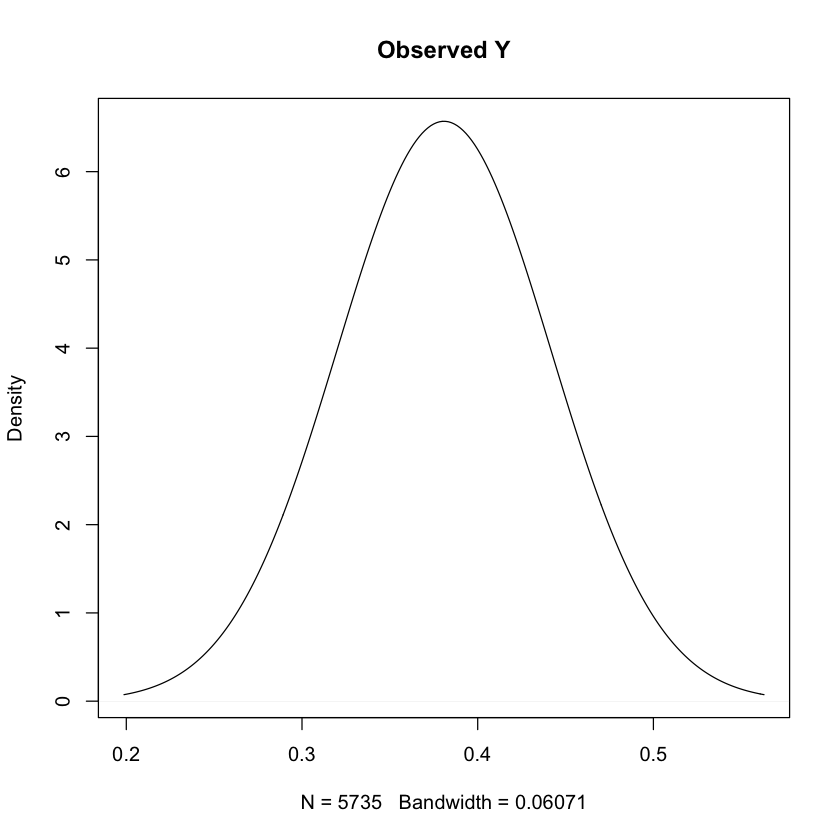

In [117]:
plot(density(all.pred$pred), main = "Observed Y")

In [108]:
outcome[1]

0.41660612
0.68744504
0.62545184
0.33019756
0.32960689
0.06439381
0.39859704
0.15777451
0.28165988
0.34176636
0.57455301


In [195]:
data = data.frame(t(data.frame(CI_list)))
data$mean = (data$X1 + data$X2)/2
# data$name = 1:nrow(data)
data$name  = c( 
    'glm',
    'lda',
    'lm',
    'rpart',
    'forest',
    'gbm',
    'xgboost',
    'svm',
    'knn',
    'tree',
    'tree_glm',
    'simple',
    'linear',
    'complex')
colnames(data) = c("lw","up","mean",'name')
data = data[order(data$mean),]

In [193]:
data = data[order(data$mean),]


In [188]:
library(ggplot2)


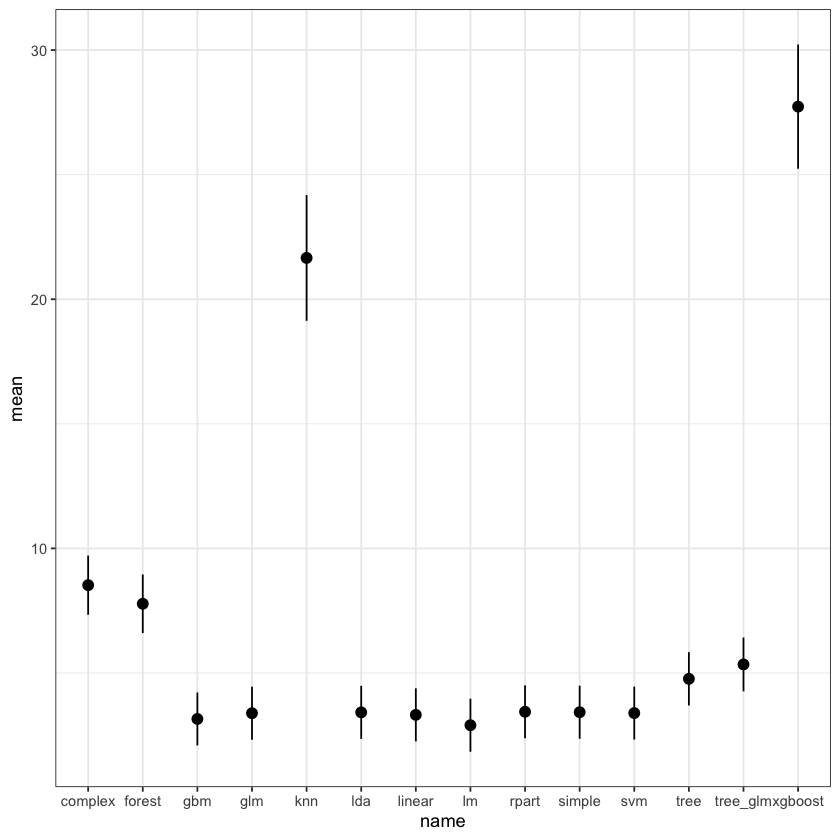

In [196]:
ggplot(data)+ 
geom_pointrange(aes(x=name,y=mean,ymin=lw,ymax=up))+
theme_bw()

In [173]:
data.frame(c( 'lib_glm',
    'lib_lda',
    'lib_lm',
    'lib_rpart',
    'lib_forest',
    'lib_gbm',
    'lib_xgboost',
    'lib_svm',
    'lib_knn',
    'lib_only_tree',
    'lib_tree_and_glm',
    'lib_only_simple',
    'lib_only_linear',
    'lib_only_complex'))

c..lib_glm....lib_lda....lib_lm....lib_rpart....lib_forest...
<chr>
lib_glm
lib_lda
lib_lm
lib_rpart
lib_forest
lib_gbm
lib_xgboost
lib_svm
lib_knn


In [180]:
1:nrow(data)

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14